# Implementing HMM for POS Tagging

In this notebook we will implement a Hidden Markov Model for Parts-of-Speech Tagging.

Associating each word in a sentence with a proper POS (part of speech) is known as POS tagging or POS annotation. POS tags are also known as word classes, morphological classes, or lexical tags. The tag in case of is a POS tag, and signifies whether the word is a noun, adjective, verb, and so on.

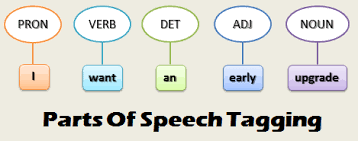

In [1]:
import nltk
import numpy as np

from tqdm import tqdm

In [2]:
# Inorder to get the notebooks running in current directory
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

import hmm

We will be making use of the Treebank corpora with the Universal Tagset.

The Treebank corpora provide a syntactic parse for each sentence. The NLTK data package includes a 10% sample of the Penn Treebank (in treebank), as well as the Sinica Treebank (in sinica_treebank).

Not all corpora employ the same set of tags. Initially we want to avoid the complications of these tagsets, so we use a built-in mapping to the "Universal Tagset".

In [3]:
# Download the treebank corpus from nltk
nltk.download('treebank')
 
# Download the universal tagset from nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/kad99kev/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/kad99kev/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
# Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

# A Look At Our Data

Let's take a look at the data we have

We have a total of *100,676* words tagged.

This includes a total of *12* unique tags with *12,408* unique words.

In [5]:
# Sample Output
for (word, tag) in nltk_data[0]:
    print(f"Word: {word} | Tag: {tag}")

Word: Pierre | Tag: NOUN
Word: Vinken | Tag: NOUN
Word: , | Tag: .
Word: 61 | Tag: NUM
Word: years | Tag: NOUN
Word: old | Tag: ADJ
Word: , | Tag: .
Word: will | Tag: VERB
Word: join | Tag: VERB
Word: the | Tag: DET
Word: board | Tag: NOUN
Word: as | Tag: ADP
Word: a | Tag: DET
Word: nonexecutive | Tag: ADJ
Word: director | Tag: NOUN
Word: Nov. | Tag: NOUN
Word: 29 | Tag: NUM
Word: . | Tag: .


In [6]:
tagged_words = [tags for sent in nltk_data for tags in sent]

In [7]:
print(f"Size of tagged words: {len(tagged_words)}")
print(f"Example: {tagged_words[0]}")

Size of tagged words: 100676
Example: ('Pierre', 'NOUN')


In [8]:
tags = list({tag for (word, tag) in tagged_words})
print(f"Tags: {tags} | Number of tags: {len(tags)}")

Tags: ['NUM', 'PRON', 'ADP', 'VERB', '.', 'DET', 'NOUN', 'ADJ', 'PRT', 'CONJ', 'ADV', 'X'] | Number of tags: 12


In [9]:
words = list({word for (word, tag) in tagged_words})
print(f"First 15 Words: {words[:15]} | Number of words: {len(words)}")

First 15 Words: ['sweeten', 'Walbrecher', 'tasty', 'breathe', 'Chapter', 'slipped', '7.272', '62', '85.1', 'Senate-House', 'directly', 'promote', 'insured', 'Jacob', 'Andy'] | Number of words: 12408


# Computing Transition and Emission Matrices

Once we have our data ready, we will need to create our transition and emission matrices.

Inorder to do this, we need to understand how we calculate these probability matrices.

## For Transition Matrices

- For a given source_tag and destination_tag do:
	- Get total counts of source_tag in corpus (all_tags)
    - Loop through all_tags and do:
        - Get all counts of instances where at timestep i, the source_tag had dest_tag at timestep i + 1
    - Get probability for dest_tag given source_tag as *P(destintation tag | source tag) = Count of destination tag to source tag / Count of source tag*  

## For Emission Matrices

- For a given word and tag do:
    - Get a list of (word, tag) from each pair of tagged words such that the iterating tag matches the given tag.
    - From this stored tags that was created from the given tag, create a list of words for which the iterating word matches the given word
    - Using the counts of the word given a tag and the total occurances of a tag, we compute the conditional probability *P(word | tag) = Count of word and tag / Count of given tag*

In [10]:
def compute_transition_matrix(tags, tagged_words):
    
    all_tags = [tag for (_, tag) in tagged_words]
    
    def compute_counts(dest_tag, source_tag):
        count_source = len([t for t in all_tags if t == source_tag])
        count_dest_source = 0
        for i in range(len(all_tags) - 1):
            if all_tags[i] == source_tag and all_tags[i + 1] == dest_tag:
                count_dest_source += 1
        return count_dest_source, count_source
    
    trans_matrix = np.zeros((len(tags), len(tags)))
    
    for i, source_tag in enumerate(tags):
        for j, dest_tag in enumerate(tags):
            count_dest_source, count_source = compute_counts(dest_tag, source_tag)
            trans_matrix[i, j] = count_dest_source / count_source
    
    return trans_matrix

In [11]:
# transition_matrix = compute_transition_matrix(tags, tagged_words)

In [12]:
# Computing Emission Probability
def compute_emission_matrix(words, tags, tagged_words):
    
    def compute_counts(given_word, given_tag):
        tags = [word_tag for word_tag in tagged_words if word_tag[1] == given_tag]
        word_given_tag = [word for (word, _) in tags if word == given_word]
        return len(word_given_tag), len(tags)
    
    emi_matrix = np.zeros((len(tags), len(words)))
        
    for i, tag in enumerate(tags):
        for j, word in enumerate(tqdm(words, desc=f"Current Tag - {tag}")):
            count_word_given_tag, count_tag = compute_counts(word, tag)
            emi_matrix[i, j] = count_word_given_tag / count_tag
    
    return emi_matrix

In [13]:
# emission_matrix = compute_emission_matrix(words, tags, tagged_words)

In [14]:
def save_matrices(observable_states, emission_matrix, hidden_states, transition_matrix, save_dir="state"):
    try:
        os.mkdir(save_dir)
    except FileExistsError:
        raise FileExistsError(
            "Directory already exists! Please provide a different output directory!"
        )
    
    np.save(save_dir + '/observable_states', observable_states)
    np.save(save_dir + '/emission_matrix', emission_matrix)    
    np.save(save_dir + '/hidden_states', hidden_states)    
    np.save(save_dir + '/transition_matrix', transition_matrix)    

In [15]:
# save_matrices(words, emission_matrix, tags, transition_matrix)

In [16]:
def load_matrices(save_dir):
    observable_states = np.load(save_dir + '/observable_states.npy')
    emission_matrix = np.load(save_dir + '/emission_matrix.npy')    
    hidden_states = np.load(save_dir + '/hidden_states.npy')    
    transition_matrix = np.load(save_dir + '/transition_matrix.npy')
    return observable_states.tolist(), emission_matrix, hidden_states.tolist(), transition_matrix

In [17]:
observable_states, emission_matrix, hidden_states, transition_matrix = load_matrices('./state')

Let us take a look at some of the observed and hidden states

In [18]:
observable_states[:15], hidden_states

(['convinced',
  'counting',
  'Anti-Deficiency',
  'unrealized',
  '6.40',
  '382-37',
  'actor',
  'Rouge',
  'Marc',
  'critics',
  'eliminated',
  'Secretary',
  'corners',
  '*T*-81',
  'least'],
 ['DET',
  'ADJ',
  'VERB',
  'PRT',
  'X',
  'PRON',
  'ADV',
  'CONJ',
  'NUM',
  '.',
  'ADP',
  'NOUN'])

We will need to write a function that tokenizes the input sentence with the index specified by our saved words list.

In [19]:
def tokenize(input_sent, words):
    lookup = {word: i for i, word in enumerate(words)}
    
    tokenized = []
    input_sent = input_sent.split(' ')
    for word in input_sent:
        idx = lookup[word]
        tokenized.append(idx)
    
    return tokenized

# Run The Markov Model

Let us now run our Hidden Markov Model with the observered and hidden states with our transition and emission matrices.

In [20]:
model = hmm.HiddenMarkovModel(
    observable_states, hidden_states, transition_matrix, emission_matrix
)

In [21]:
model.print_model_info()

**************************************************
Observable States: ['convinced', 'counting', 'Anti-Deficiency', 'unrealized', '6.40', '382-37', 'actor', 'Rouge', 'Marc', 'critics', 'eliminated', 'Secretary', 'corners', '*T*-81', 'least', 'Congress', 'alleging', 'risk', 'star', 'vision', 'notified', 'where', 'Gov.', 'hedging', 'evident', 'yen-denominated', 'subcontractor', 'unrealistically', 'semiliterate', 'railings', 'content', 'cotton', 'public', 'Items', 'kicked', 'supposedly', 'exposed', 'inspection', 'Betting', 'printed', 'Convention', 'diseases', 'firm', 'demonstrates', 'Mostly', 'senses', 'sufficiently', 'discredit', 'Bhutto', 'execution', 'Coxon', 'stature', '58.64', 'egregious', '306', '*T*-167', 'zone', 'shame', 'Geneva', 'platforms', 'substantially', 'oust', 'attended', 'Tower', 'Thai', 'Coleco', 'centralized', 'casting', 'Savin', '30-share', 'represented', 'contends', 'mother', 'lyrics', '62%-owned', '77.56', 'ASSOCIATES', '210', '3.75', 'arrangement', 'takes', 'Alurrald

In [22]:
input_sent = 'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 .'
input_tokens = tokenize(input_sent, observable_states)
print(input_tokens)

[459, 9165, 5817, 483, 3096, 10713, 5817, 9219, 166, 8733, 2232, 12367, 9530, 2522, 2367, 1640, 1038, 9079]


# Forward Algorithm

In [23]:
alpha, a_probs = model.forward(input_tokens)
hmm.print_forward_result(alpha, a_probs)

**************************************************
Alpha:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.07674884e-32 0.00000000e+00 0.00000000e+00
  5.78704351e-39 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.34737310e-22 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.70169077e-35 0.00000000e+00 0.00000000e+00
  2.90053235e-42 9.27114011e-43 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.67948823e-27
  3.34058483e-31 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.000

# Backward Algorithm

Let us verify the output of the Forward Algorithm by running the Backward Algorithm.

In [24]:
beta, b_probs = model.backward(input_tokens)
hmm.print_backward_result(beta, b_probs)

**************************************************
Beta:
[[1.95362856e-50 3.24947814e-47 1.20687388e-45 6.99495502e-41
  4.58408154e-37 1.62217948e-34 1.00401297e-32 2.81231267e-30
  1.05664092e-26 3.86450232e-24 3.45435652e-22 1.67030781e-20
  1.38792444e-17 7.90791958e-14 2.69963398e-10 1.18991076e-06
  5.76746439e-03 1.00000000e+00]
 [2.14067059e-50 1.19434578e-46 1.13434538e-45 7.66465786e-41
  1.48615065e-37 5.96232114e-34 3.22995506e-33 8.53625372e-31
  8.93840665e-27 4.23449300e-24 2.55158414e-21 1.46002723e-20
  4.49962503e-18 8.66503040e-14 2.95809919e-10 1.11840168e-06
  2.11983170e-02 1.00000000e+00]
 [3.37803568e-51 6.44709638e-47 1.24693532e-45 1.20950359e-41
  1.45785637e-37 3.21846986e-34 4.18398796e-32 1.19833922e-29
  2.40480978e-25 6.68214368e-25 3.25678231e-21 4.00630030e-19
  4.41395832e-18 1.36736507e-14 4.66795997e-11 1.22940912e-06
  1.14428832e-02 1.00000000e+00]
 [7.56871765e-51 7.89253368e-47 3.10170241e-45 2.70997469e-41
  1.89710743e-37 3.94004995e-34 9.9299

# Viterbi Algorithm

This algorithm will give us the POS for each token or word. This is useful to generate POS Tagger for different sentences.

In [25]:
path, delta, phi = model.viterbi(input_tokens)
hmm.print_viterbi_result(input_tokens, observable_states, hidden_states, path, delta, phi)

**************************************************
Starting Forward Walk
State=0 : Sequence=1 | phi[0, 1]=11.0
State=1 : Sequence=1 | phi[1, 1]=11.0
State=2 : Sequence=1 | phi[2, 1]=11.0
State=3 : Sequence=1 | phi[3, 1]=11.0
State=4 : Sequence=1 | phi[4, 1]=11.0
State=5 : Sequence=1 | phi[5, 1]=11.0
State=6 : Sequence=1 | phi[6, 1]=11.0
State=7 : Sequence=1 | phi[7, 1]=11.0
State=8 : Sequence=1 | phi[8, 1]=11.0
State=9 : Sequence=1 | phi[9, 1]=11.0
State=10 : Sequence=1 | phi[10, 1]=11.0
State=11 : Sequence=1 | phi[11, 1]=11.0
State=0 : Sequence=2 | phi[0, 2]=11.0
State=1 : Sequence=2 | phi[1, 2]=11.0
State=2 : Sequence=2 | phi[2, 2]=11.0
State=3 : Sequence=2 | phi[3, 2]=11.0
State=4 : Sequence=2 | phi[4, 2]=11.0
State=5 : Sequence=2 | phi[5, 2]=11.0
State=6 : Sequence=2 | phi[6, 2]=11.0
State=7 : Sequence=2 | phi[7, 2]=11.0
State=8 : Sequence=2 | phi[8, 2]=11.0
State=9 : Sequence=2 | phi[9, 2]=11.0
State=10 : Sequence=2 | phi[10, 2]=11.0
State=11 : Sequence=2 | phi[11, 2]=11.0
State=0